### K-Means using Pytorch
This notebook demonstrates the implementation of the Kmeans clustering algorithm using PyTorch. The notebook is structured following the concepts and methods discussed in [Lesson 12](https://course.fast.ai/Lessons/lesson12.html) of fast ai course on deep learning. It aims to provide a hands-on practice on key aspects such as tensor broadcasting, and utilizes tools like partial functions and animation techniques with Matplotlib. 



In [32]:
import torch
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

torch.random.manual_seed(101)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

In [33]:
def plot_data(centroids, X, assignments, ax=None):
    if ax is None: fig, ax = plt.subplots()
    for i in range(centroids.shape[0]):
        centriod = centroids[i]
        samples = X[(assignments[i,:] == 1), :]
        ax.scatter(samples[:, 0], samples[:, 1], s=1)
        ax.plot(*centriod, marker='x', markersize=5, color='black')


### Create Data

In [34]:
n_clusters = 5
n_samples = 250
r_min, r_max = 0, 100

In [35]:
from torch.distributions.multivariate_normal import MultivariateNormal
def get_sample(m, n_samples): return MultivariateNormal(m, torch.diag(torch.tensor([5.0, 5.0]))).sample((n_samples, ))

In [36]:
centroids = torch.rand((n_clusters, 2)) * (r_max - r_min) + r_min
data = torch.cat([get_sample(centroids[i,:], n_samples) for i in range(n_clusters)])
assignment = torch.zeros((n_clusters, n_samples * n_clusters))
for i in range(n_clusters):
    assignment[i, i*n_samples:i*n_samples+n_samples] = 1

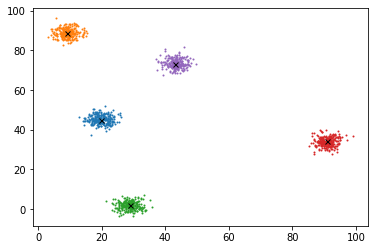

In [37]:
plot_data(centroids, data, assignment)

In [38]:
def update_once(C, X, A, bs=100):
    Cnew = torch.zeros_like(C).to(C.device)
    Cnt = torch.zeros((C.shape[0])).to(C.device)
    Anew = torch.zeros((C.shape[0], X.shape[0])).to(C.device)
    for i in range(0, X.shape[0], bs):
        slc = slice(i, min(i+bs, X.shape[0]))
        x = X[slc] # bs, 2
        dist = ((C[:,None,:] - x[None, :, :]) ** 2).sum(2).sqrt() # n_clusters, bs
        assignment = (dist <= dist.min(dim=0)[0]).float() # n_clusters, bs
        Y = assignment[:,:,None] * x[None, :, :] # n_clusters, bs, 2
        Cnew += Y.sum(1)
        Cnt += assignment.sum(1)
        Anew[:, slc] = assignment
    C[:] = Cnew / Cnt[:, None]
    A[:] = Anew
    return 

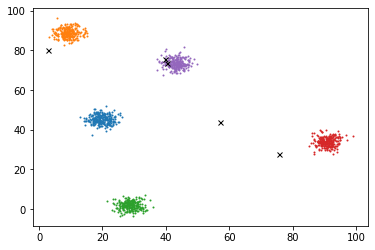

In [39]:
torch.random.manual_seed(1)
C0 = torch.rand((n_clusters, 2)) * (r_max - r_min) + r_min
X = data.clone()
A = assignment.clone()
C = C0.clone()
plot_data(C, X, A)

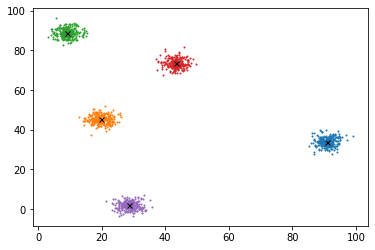

In [40]:
def kmeans(C, X, A, n_iter=10, batch_size=100):
    for i in range(n_iter):
        update_once(C, X, A, bs=batch_size)
    return

kmeans(C, X, A, n_iter=3)
plot_data(C, X, A)

In [41]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [42]:
def do_once(itr, C, X, A):
    if itr > 0:
        # C, A = update_once(C, X)
        update_once(C, X, A)
    ax.clear()
    plot_data(C, X, A, ax)


In [43]:
X = data.clone()
A = assignment.clone()
C = C0.clone()
fig, ax = plt.subplots()
ani = FuncAnimation(fig, do_once, frames=5, interval=1000, fargs=(C, X, A), repeat=False)
plt.close()
HTML(ani.to_jshtml())

### GPU vs CPU timing

In [44]:
Xc, Ac, Cc = data.clone(), assignment.clone(), C0.clone()
Xg, Ag, Cg = Xc.cuda(), Ac.cuda(), Cc.cuda()
print(Cc.device, Xc.device, Ac.device)
print(Cg.device, Xg.device, Ag.device)

cpu cpu cpu
cuda:0 cuda:0 cuda:0


In [45]:
%time kmeans(Cc, Xc, Ac, n_iter=10)

CPU times: user 524 ms, sys: 0 ns, total: 524 ms
Wall time: 47.8 ms


In [47]:
%time kmeans(Cg, Xg, Ag, n_iter=10, batch_size=100)

CPU times: user 66.1 ms, sys: 510 µs, total: 66.6 ms
Wall time: 65.3 ms
